# YZ투자 MBTI : 나는 어떤 유형일까?

<h1>팀 소개</h1>

<img src="https://drive.google.com/uc?id=1zgXrqgGbydopNbL4bJq2hBUOI0aG8Uju" width = 800>

안녕하세요.<br>
팀 <mark>Bite Datalab</mark> 입니다. <br>
다양한 분야에서 데이터 분석과 AI를 활용해 더 나은 미래를 앞당기고자 하는 목표를 가지고 있습니다.

<h1>도입</h1>


**"밀레니얼 세대, 2020년부터 구매력 1위로"** _Brand Brief_

2020년 기준 Y세대는 모든세대의 구매력을 앞서고 1위가 되었습니다. 또한 Z세대 역시 경제력이 빠르게 성장하여 2030년에는 M세대를 초월하고 글로벌 소득의 27%를 차지하게 될것으로 전망되고 있습니다. 이처럼 YZ세대는 구매력 향상을 바탕으로 주식시장에서도 영향을 미칠 것으로 사료됩니다. 따라서 주 고객이 될 <mark>YZ세대의 취향과 특성을 분석하고 추출하여 해석하는 것</mark>이 앞으로 NH투자증권의 의사결정과 가치판단시 중요한 척도가 될 것 입니다.

<h1>0. 분석용 데이터 생성</h1>

In [100]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
pd.set_option('display.max_colwidth', -1)  # or 199

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx

from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

import warnings
warnings.filterwarnings(action='ignore')

import plotly.graph_objects as go
import plotly.express as px
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "notebook_connected"

plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

## 데이터 로드

In [7]:
cd data

/Users/jaeyeobjeong/Desktop/포트폴리오/프로젝트/Y&Z 세대 투자자 프로파일링/data


In [17]:
cus_info = pd.read_csv('2_cus_info.csv')
act_info = pd.read_csv('2_act_info.csv')
trd_kr = pd.read_csv('2_trd_kr.csv')
iem_info = pd.read_csv('2_iem_info.csv')
trd_oss = pd.read_csv('2_trd_oss.csv')
kr_iem_info = pd.read_csv('kr_iem_crawl.csv',encoding = 'utf-8-sig') 

<외부 데이터>

- 종목(iem_info)별 WICS 크롤링 데이터 https://wisefn.finance.daum.net

## 데이터 전처리

### 분석용 파생변수 생성

In [18]:
#cus_info : YZ X세대 나누기
def split_mz (x):
    if 20 <= x <= 35 :
        return 'MZ'
    else:
        return 'X'

#cus_info : 성별, 주소, 고객등급, 고객투자성향 라벨링
addr = {
41: '경기' , 11: '서울' , 48: '경남' , 26: '부산' , 27: '대구',
47: '경북' , 28: '인천' , 44: '충남' , 46: '전남' , 30: '대전',
29: '광주' , 43: '충북' , 45: '전북' , 42: '강원' , 31: '울산',
50: '제주' , 36: '세종', '-' : '모름'}

cus_grd = {'01': '탑클래스',
'02': '골드', 
'03': '로얄', 
'04': '그린', 
'05': '블루', 
'09': '등급 없음',
'_ ': '해당 사항 없음'}

ivs_icn = {'01': '안정형' , '02': '안정추구형' , '03': '위험중립형',
'04': '적극투자형' , '05': '공격투자형', 
'09': '전문투자자형' , '00' :'정보제공미동의',
'_ ': '해당사항없음', '-': '해당사항없음'}


trd_kr['orr_dt'] = trd_kr['orr_dt'].astype(str).apply(pd.to_datetime)
trd_oss['orr_dt'] = trd_oss['orr_dt'].astype(str).apply(pd.to_datetime)

cus_info['generation'] = cus_info['cus_age'].apply(lambda x : split_mz(x))
trd_oss['orr_pr'] = trd_oss['orr_pr']*trd_oss['trd_cur_xcg_rt']
cus_info['sex_dit_cd'] = cus_info['sex_dit_cd'].apply(lambda x : "남자" if x == 1 else "여자")
cus_info['zip_ctp_cd'] = cus_info['zip_ctp_cd'].apply(lambda x : addr[int(x)] if x != "-" else "-")
cus_info['tco_cus_grd_cd'] = cus_info['tco_cus_grd_cd'].apply(lambda x : cus_grd[x])
cus_info['ivs_icn_cd'] = cus_info['ivs_icn_cd'].apply(lambda x : ivs_icn[x])
cus_info2 = cus_info.copy()

### 데이터 병합

In [20]:
cus_act_kr = trd_kr.merge(act_info,on = 'act_id').merge(cus_info,on = 'cus_id')
cus_act_kr = cus_act_kr.merge(kr_iem_info[['iem_cd','wics_nm1','wics_nm2','wics_nm3']],on = 'iem_cd',how = 'left')
cus_act_kr['wics_nm1'] = cus_act_kr['wics_nm1'].fillna('기타') #크롤링 안된 것들
cus_act_oss = trd_oss.iloc[:,0:10].merge(act_info,on = 'act_id').merge(cus_info,on = 'cus_id')
cus_act_oss['wics_nm1'] = '해외주식'
cus_act_trd = pd.concat([cus_act_kr,cus_act_oss],axis = 0,sort =  False)
cus_act_trd['tot_pr'] =  cus_act_trd['cns_qty'] * cus_act_trd['orr_pr'] #체결 총 거래액

### iem_cd에 이름과 종목을 부여

In [21]:
iem_name = kr_iem_info[['iem_cd','iem_krl_nm','wics_nm3']]
iem_name_dict = iem_name.set_index('iem_cd').to_dict()

kr_iem_cd = iem_name_dict['iem_krl_nm'].keys()
trd_kr = trd_kr.query("iem_cd in @kr_iem_cd")

<h1>1. EDA</h1>

우선, 저희는 YZ세대의 구매력이 상승함에 따라 <mark>주식거래에 있어서도 영향력이 증가</mark>했을 것이라 판단하였습니다. 특히, 2020년은 Y세대의 구매력이 1위가 되었기에 이들의 주식 거래 성장률 비교를 통해 과연 이러한 경향이 수치로 드러나는지 파악하였습니다. 또한 YZ세대의 특성을 파악하기 위해 <mark>다른세대와의 비교를 중점적으로</mark> 분석을 진행하였습니다.

## 1.1. 주식 거래 성장률 비교
* 성장률 지표 : 분기별 총거래액/직전분기 총거래액
* 총거래액 : 채결가격 * 채결수량

In [22]:
cus_act_trd3 = cus_act_trd.reset_index()
cus_act_trd3['month'] = cus_act_trd3['orr_dt'].apply(lambda x : x.month)
cus_act_trd3['year'] = cus_act_trd3['orr_dt'].apply(lambda x : x.year)
cus_act_trd3['year_month'] = cus_act_trd3['year'].astype(str)+ '-'+cus_act_trd3['month'].astype(str)

def section (x):
    if x in [1,2,3]:
        return 1
    elif x in [4,5,6]:
        return 2
    elif x in [7,8,9]:
        return 3
    else:
        return 4
cus_act_trd3['section'] = cus_act_trd3['month'].apply(lambda x : section(x))
cus_act_trd3['section2'] = cus_act_trd3['year'].astype(str) + '-'+ cus_act_trd3['section'].astype(str)

In [23]:
tot_pr2 = cus_act_trd3.groupby(['generation','section2']).tot_pr.agg([('tot_pr_sum','sum')]).reset_index()
tot_pr_mz = tot_pr2.query('generation == "MZ"')["tot_pr_sum"]
tot_pr_mz1 = tot_pr_mz[1:]
tot_pr_mz2 = tot_pr_mz[:-1]
mz = []
for i,j in zip(tot_pr_mz1,tot_pr_mz2):
    mz.append((i-j)/i)
    
tot_pr_others = tot_pr2.query('generation == "X"')["tot_pr_sum"]
tot_pr_others1 = tot_pr_others[1:]
tot_pr_others2 = tot_pr_others[:-1]
others = []
for i,j in zip(tot_pr_others1,tot_pr_others2):
    others.append((i-j)/i)

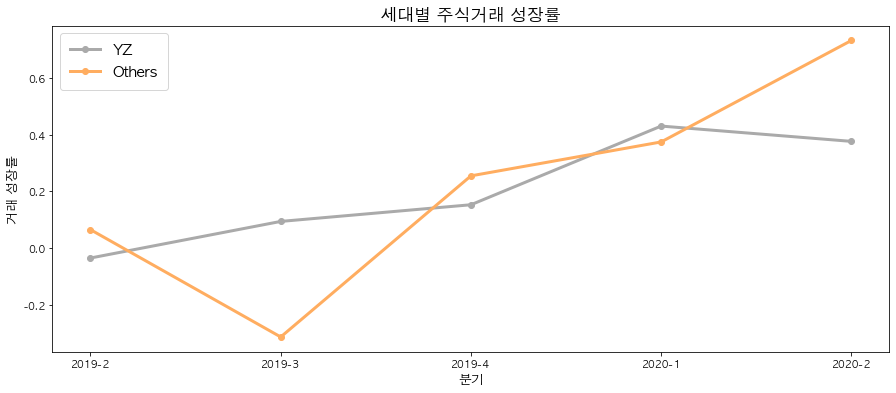

In [101]:
plt.rcParams['figure.figsize'] = [15, 6]
x_values = tot_pr2.query('generation == "MZ"')["section2"][1:]
plt.plot(x_values, others, color='#AAAAAA',  marker='o', linewidth=3)
plt.plot(x_values, mz, color='#ffad60', marker='o', linewidth=3)
plt.title('세대별 주식거래 성장률',size = 17, weight='bold')
plt.legend(['YZ','Others'],loc='upper left',borderpad=0.7,fontsize = 15)
plt.xlabel("분기",size = 13, weight='bold')
plt.ylabel("거래 성장률",size = 13, weight='bold')
plt.show()

**세대별 주식거래 성장률**을 시각화 하였습니다.

YZ세대는 다른세대에 비해 급격한 주식거래 성장률을 보여주고 있습니다.
특히 20년도 이후에 다른 세대보다 증가율이 크다는 점을 알 수 있습니다.
이는 <mark>구매력이 높아진 YZ세대의 관심이 주식시장에서도 점차 드러나고 있음</mark>을 보여줍니다.

## 1.2. 주 거래 종목 비교

구매력 향상을 바탕으로 주식시장에서도 큰 영향을 미치고 있는 YZ세대들의 특성을 파악하기 위해 다른세대와 비교하여 <mark>주로 어떤 종목에 투자를 하고 있을지</mark>분석해보았습니다.

### 1.2.1. 고객 별 종목 리스트 형태로 데이터 변환
- 19.01 ~ 20.06 까지 매수/매도한 종목을 리스트 형태로 만들었습니다.
- 거래내용이 없는 계좌/고객의 경우 분석대상에서 제외하였습니다.

In [25]:
act_iem_lst = trd_kr.groupby('act_id')['iem_cd'].agg([('act_iem_lst',list)]).reset_index()
act_info = pd.merge(act_info, act_iem_lst, on = 'act_id', how = 'left')

print('거래가 없는 계좌 비율  : {:.4} %' \
      .format(act_info['act_iem_lst'].isnull().mean() * 100))

#거래가 없는 계좌 제외
act_info.dropna(subset = ['act_iem_lst'], inplace = True)

거래가 없는 계좌 비율  : 55.04 %


In [26]:
cus_iem_lst = act_info.groupby('cus_id')['act_iem_lst'].agg([('cus_iem_lst',list)]) \
['cus_iem_lst'].apply(lambda cus_iem_lst : sum(cus_iem_lst, [])).reset_index()

cus_info = pd.merge(cus_info, cus_iem_lst, on = 'cus_id', how = 'left')
print('거래가 없는 고객 비율  : {:.4} %' \
      .format(cus_info['cus_iem_lst'].isnull().mean()* 100))

#거래가 없는 고객 제외
cus_info.dropna(subset = ['cus_iem_lst'], inplace = True)

거래가 없는 고객 비율  : 1.96 %


In [27]:
# iem_cd에 상품의 한글이름과 업종 이름 추가
cus_info['iem_krl_lst'] = cus_info['cus_iem_lst'].apply(lambda iem_lst : list(map(lambda i: iem_name_dict['iem_krl_nm'][i], iem_lst)))
cus_info['wics_nm3_lst'] = cus_info['cus_iem_lst'].apply(lambda iem_lst : list(map(lambda i: iem_name_dict['wics_nm3'][i], iem_lst)))

### 1.2.2.  주식 종목에 대한 연관 분석 (전체고객)

비교를 위해 <mark>전체 고객 대상으로 주식 종목에 대해 연관분석</mark>을 진행하였습니다.

In [28]:
def single_iem_support(cus_iem_lst, min_support, return_encoder_array = False, single_iem = True):
    encoder = TransactionEncoder()
    encoder_array = encoder.fit_transform(cus_iem_lst)

    df = pd.DataFrame(
        encoder_array, 
        columns=encoder.columns_
    )
    if return_encoder_array : 
        return df
    
    else: 
        apriori_iem_df = apriori(df, 
                min_support=min_support,
                use_colnames=True)

        apriori_iem_df['length'] = apriori_iem_df['itemsets'].apply(lambda x: len(x))
        apriori_single_iem_df = apriori_iem_df.query('length == 1')
        
        if single_iem:
            return apriori_single_iem_df
        else :
            return apriori_iem_df

In [29]:
print ('\033[1m' + '고객들이 가지고 있는 비율이 가장 많은 주식 TOP 10')
single_iem_support(cus_info['iem_krl_lst'], min_support = 0.1).sort_values(by = 'support',ascending = False).head(10)

고객들이 가지고 있는 비율이 가장 많은 주식 TOP 10


,support,itemsets,length
2,0.455018,(삼성전자보통주 ),1
10,0.165953,(카카오보통주 ),1
9,0.160343,(에스케이하이닉스보통주 ),1
8,0.133823,(씨젠 ),1
12,0.125969,(현대자동차보통주 ),1
11,0.124541,(파미셀보통주 ),1
4,0.123725,(셀트리온보통주 ),1
0,0.120665,(남선알미늄보통주 ),1
7,0.119339,(신풍제약보통주 ),1
5,0.117911,(셀트리온헬스케어 ),1


### 1.2.3. 세대 별 주거래 종목 비교

이후,<mark>주거래 종목 Top10 주식 세대 별 구매 비율</mark>을 분석하였습니다.

In [30]:
# YZ 세대와 나머지로 나누기
mz_df = cus_info.query('cus_age < 40 and cus_age >= 20')
others_df = cus_info.query('cus_age >= 40 or cus_age < 20')

# 나뉘진 데이터 별로 분석 진행
single_mz_apriori_iem_df = single_iem_support(mz_df['iem_krl_lst'], min_support = 0.1)
single_others_apriori_iem_df = single_iem_support(others_df['iem_krl_lst'], min_support = 0.1)

# 모든 고객들에 대해 가장 많이 가지고 있는 주식 TOP 10
top_10_iem = single_iem_support(cus_info['iem_krl_lst'], min_support = 0.1).sort_values(by = 'support',ascending = False).head(10) \
             ['itemsets'].apply(lambda x : list(x)[0].strip()).to_list()

# 그룹 별 TOP10 주식 보유비율 계산
mz_iem_array = single_iem_support(mz_df['iem_krl_lst'], min_support = 0.1, return_encoder_array = True)
mz_iem_array.columns = list(map(lambda colname : colname.strip(), list(mz_iem_array.columns)))

mz_index = mz_iem_array[top_10_iem].sum(axis = 1).apply(lambda value :np.where(value >= 1, "거래경험 O", "거래경험 X")).value_counts(1).index
mz_value = mz_iem_array[top_10_iem].sum(axis = 1).apply(lambda value :np.where(value >= 1, "거래경험 O", "거래경험 X")).value_counts(1).values

others_iem_array = single_iem_support(others_df['iem_krl_lst'], min_support = 0.1, return_encoder_array = True)
others_iem_array.columns = list(map(lambda colname : colname.strip(), list(others_iem_array.columns)))

others_index = others_iem_array[top_10_iem].sum(axis = 1).apply(lambda value :np.where(value >= 1, "거래경험 O", "거래경험 X")).value_counts(1).index
others_value = others_iem_array[top_10_iem].sum(axis = 1).apply(lambda value :np.where(value >= 1, "거래경험 O", "거래경험 X")).value_counts(1).values

In [31]:
data1 = {
   "values": mz_value,
    'marker': {
      'colors': [
        '#66b8c9','#FF7182'
      ]
    },
   "labels": mz_index,
   "domain": {"column": 0},
   "name": "YZ 세대",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
data2 = {
   "values": others_value,
    'marker': {
      'colors': [
        '#66b8c9','#FF7182'
      ]
    },
   "labels": others_index,
   "domain": {"column": 1},
   "name": "나머지 세대",
   "hoverinfo":"label+percent+name",
   "hole": .4,
   "type": "pie"
}
data = [data1,data2]

layout = go.Layout(
   {
      "title":"세대별 거래량 TOP10 종목 거래경험 비율",
      "grid": {"rows": 1, "columns": 2},
      "annotations": [
         {
            "font": {"size": 14},
            "showarrow": False,
            "text": "YZ 세대",
            "x": 0.205, "y": 0.5
         },
         {
            "font": {"size": 14},
            "showarrow": False,
            "text": "나머지 세대",
            "x": 0.815, "y": 0.5
         }
      ]
   }
)
fig = go.Figure(data = data, layout = layout)
fig.show()

분석 결과, 거래량이 많은 종목을 거래한 고객의 비율이 YZ세대가 더 높습니다.

<mark>이를 통해 YZ세대는 상대적으로 인지도가 높은 종목을 주로 거래한다</mark>는 점을 알 수 있습니다.

## 1.3. 종목 거래 패턴 비교

**위에서 YZ세대는 인지도가 높은 종목을 주로 거래한다는 결과를 도출했습니다. 인지도가 높은 종목은 그 수가 많지 않기 때문에, 거래 하는데 있어 <mark> 패턴을 보이지 않을까?</mark> 라는 생각을 하였습니다. 이를 바탕으로 세대별 패턴 구매 비율을 연관분석을 통해 비교해 보았습니다.**

In [32]:
mz_apriori_iem_df = single_iem_support(mz_df['iem_krl_lst'], min_support = 0.05, single_iem=False)
others_apriori_iem_df = single_iem_support(others_df['iem_krl_lst'], min_support = 0.05, single_iem=False)

In [33]:
# YZ 세대와 나머지 고객들의 상품에 대한 거래 패턴분석
mz_iem_rules = association_rules(
    mz_apriori_iem_df, 
    metric="confidence",
    min_threshold=0.5, 
    support_only=False
)

others_iem_rules = association_rules(
    others_apriori_iem_df, 
    metric="confidence",
    min_threshold=0.5, 
    support_only=False
)

**연관분석에 사용되는 지표설명**

예시 : A -> B

- 지지도(Support) : A상품과 B상품의 동시구매 횟수 / 전체 리스트  
    => A상품과 B상품을 같이 구매하는 **횟수**가 많습니다.
<br><br>
- 신뢰도(Confidence) : A상품과 B상품의 동시구매 횟수 / A상품 구매횟수  
    => A상품과 다른 상품을 구매하는 경우보다 B상품을 같이 구매하는 **비율**이 높습니다.
<br><br>
- 향상도(Lift) : A상품과 B상품의 동시구매 횟수 / { (A 상품 등장 횟수) * (B 상품 등장 횟수) }  
    => A상품과 B상품을 같이 구매하는 **연관성**이 높습니다.

In [34]:
mz_iem_rules['labels'] = 'YZ'
others_iem_rules['labels'] = 'Others'

iem_rules = pd.concat([mz_iem_rules, others_iem_rules], axis = 0)

In [35]:
fig = px.scatter(iem_rules, x = 'support', y = 'lift', color = 'labels',
                 color_discrete_sequence=['#ffad60','#C0BCB6'],
                 labels={
                     "support": "지지도(Support)",
                     "lift": "향상도(Lift)",
                     "labels": "세대"
                 })
fig.add_shape(type='rect',
              x0=0.048, y0=2.95,
              x1=.09, y1=4.15,
              line=dict(color='#d9534f', dash="dot"),
             )
fig.add_trace(go.Scatter(
    x=[0.082],
    y=[4.3],
    text= ["YZ 세대의 특징"],
    mode="text",
    textfont = dict(color="#d9534f",size = 15),
    showlegend=False
))

fig.update_traces(marker=dict(size=10),
                  selector=dict(mode='markers'))

fig.update_layout(paper_bgcolor='#ffffff',
                 plot_bgcolor= '#ffffff', title_text="그룹별 특성비교",
                 
)
fig.update_xaxes(gridcolor = 'rgb(233,233,233)')
fig.update_yaxes(gridcolor = 'rgb(233,233,233)')
fig.show()

**지지도는 낮지만 향상도가 높은 것의 의미**  

: A상품과 다른 상품을 구매하는 경우보다 B상품을 같이 구매하는 횟수는 적지만 비율이 높습니다.

### YZ세대와 나머지 세대의 향상도를 통한 주식 거래 성향 비교

In [36]:
# YZ세대에서 Lift가 3이 넘는 조합
mz_iem_rules.query('lift >= 3').sort_values(by = 'lift', ascending = False) # 15개

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,labels
20,(부광약품보통주 ),(신풍제약보통주 ),0.110213,0.136568,0.060797,0.551630,4.039241,0.045745,1.925715,YZ
10,(와이비엠넷 ),(남선알미늄보통주 ),0.088649,0.147050,0.051213,0.577703,3.928614,0.038177,2.019786,YZ
49,(이원다이애그노믹스 ),(신풍제약보통주 ),0.116502,0.136568,0.059599,0.511568,3.745890,0.043688,1.767764,YZ
50,(신풍제약보통주 ),(파미셀보통주 ),0.136568,0.136568,0.069182,0.506579,3.709358,0.050532,1.749889,YZ
51,(파미셀보통주 ),(신풍제약보통주 ),0.136568,0.136568,0.069182,0.506579,3.709358,0.050532,1.749889,YZ
6,(디피씨보통주 ),(남선알미늄보통주 ),0.100329,0.147050,0.054507,0.543284,3.694550,0.039754,1.867570,YZ
15,(디피씨보통주 ),(신풍제약보통주 ),0.100329,0.136568,0.050614,0.504478,3.693971,0.036912,1.742469,YZ
4,(국일제지 ),(남선알미늄보통주 ),0.108715,0.147050,0.057802,0.531680,3.615644,0.041815,1.821299,YZ
9,(아난티 ),(남선알미늄보통주 ),0.110512,0.147050,0.058101,0.525745,3.575282,0.041850,1.798506,YZ
12,(초록뱀미디어 ),(남선알미늄보통주 ),0.101827,0.147050,0.052710,0.517647,3.520211,0.037737,1.768311,YZ


In [37]:
# 나머지 세대에서 Lift가 3이 넘는 조합
others_iem_rules.query('lift >= 3').sort_values(by = 'lift', ascending = False) # 15개

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,labels
3,(NAVER보통주 ),(카카오보통주 ),0.08198,0.141841,0.054138,0.660377,4.655768,0.04251,2.526802,Others


위와 같이 <mark>YZ세대와 나머지 세대의 향상도를 통한 주식 구매 성향 비교</mark>를 해보았습니다. 향상도를 3이상으로 보았을때 YZ세대의 거래종목 조합은 15개인 반면, 다른 세대의 경우에는 1개의 조합밖에 없습니다. 이는 <mark>YZ세대의 거래종목 조합이 연관성이 크며, 패턴 거래를 하는 비율이 다른세대에 비해 높다는 점</mark>을 보여줍니다.

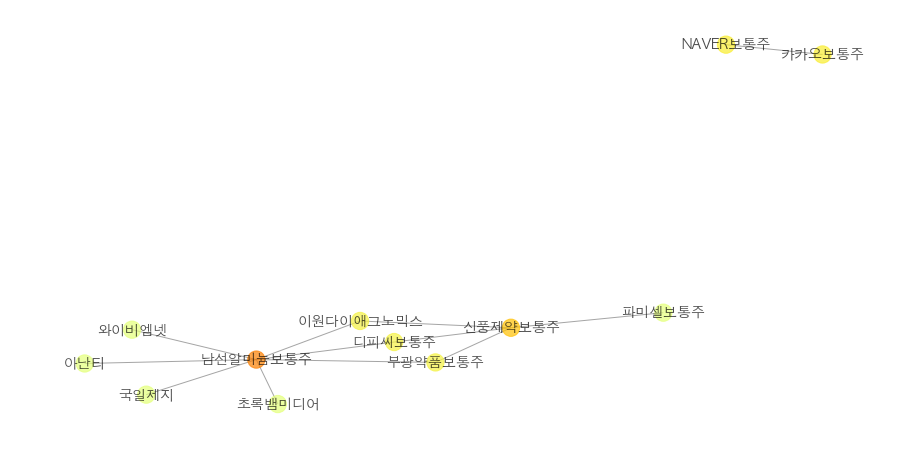

In [103]:
G = nx.Graph()
ar = mz_iem_rules.query('lift >= 3') \
.apply(lambda x : (list(x['antecedents'])[0].strip(), list(x['consequents'])[0].strip()), axis = 1)
G.add_edges_from(ar)
pr = nx.pagerank(G)

plt.figure(figsize = (16,8)); plt.axis('off')
nx.draw_networkx(G, font_family ='AppleGothic', font_size = 14,
                node_color = list(pr.values()), 
                alpha = 0.7, edge_color = '.5', cmap = plt.cm.Wistia)

<mark>YZ 세대에서 향상도가 높게 나온 주식들</mark>을 시각화한 결과입니다.

예를 들어, Naver보통주를 거래한 사람은 카카오보통주를 같이 거래하는 성향을 보이며, 남선알미늄보통주를 거래한 사람은 아난티, 와이비엠넷 등을 같이 거래하는 성향을 보입니다.

## 1.4. YZ세대는 하나의 집단으로 정의할 수 없음

YZ세대는 자신만의 가치, 개인화, 능동적, 공유 등의 가치를 중요시 하는 세대입니다. 이들은 이러한 가치를 금융에도 반영하고 있습니다.

<img src="https://drive.google.com/uc?id=169qJPFATrJhQ0h42LPODZNyNuDkvQvdI" width = 600 >

위의 리서치를 보면 YZ세대는 무모한 단타가 아닌 장기 투자를 하며 근로소득이 끝날때 까지 기간이 많이 남아 상대적으로 느긋하게 투자 한다고합니다.

<img src="https://drive.google.com/uc?id=10CGJxQqt6d3OTQ5BMGMIKYTm7lliHPp5">


반면, 위의 자료에서는 이와 반대로 YZ세대는 빠른 주택 구매를 위해 high risk high return의 모험적인 단기투자를 한다고 합니다. 

이처럼 <mark>YZ 세대는 단 하나의 집단으로 정의될 수 없음</mark>을 염두해두고 분석을 시작하였습니다.

### YZ세대 중 투자성향이 분류되지 않은 고객 비율

In [39]:
def ivs_response(x):
    if (x == '해당사항없음') or (x == '정보제공미동의'):
        return '투자성향 분류 X'
    else:
        return '투자성향 분류 O'
cus_info2['ivs_response'] = cus_info2['ivs_icn_cd'].apply(lambda x : ivs_response(x))
cus_ivs = cus_info2.groupby('generation')['ivs_response'].sum().reset_index()

mz_size = cus_info2.query('generation == "MZ"')['cus_id'].count()
df = cus_info2.query("generation == 'MZ'").groupby(['ivs_response']).size().reset_index().rename({0:'cnt'},axis = 1)

fig = px.pie(df, values='cnt', names='ivs_response',
             title='YZ세대 중 투자성향이 분류되지 않은 비율',
             color_discrete_sequence=['#66b8c9','#FF7182'])
fig.show()

### 기존분류(투자유형별) 거래종목수, 총거래량,총거래액

In [40]:
# 아이디별 거래종목수
iem_cnt  = cus_act_trd.groupby('cus_id')['iem_cd'].agg([('iem_cnt', 'nunique')]).reset_index()                       
# 아이디별 총 거래량
qty_cns_sum = cus_act_trd.groupby('cus_id').cns_qty.agg([('qty_cns_sum','sum')]).reset_index()
# 매수 종목 총 거래액
tot_pr = cus_act_trd.query('sby_dit_cd == 2').groupby('cus_id').tot_pr.agg([('tot_pr_sum','sum')]).reset_index()

In [41]:
data = iem_cnt\
    .merge(qty_cns_sum, on = 'cus_id')\
    .merge(tot_pr, on = 'cus_id')\
    .merge(cus_info2[['cus_id','cus_age','generation']], on = 'cus_id')
data = data.fillna(0)

In [42]:
cols = ['cus_id','iem_cnt','qty_cns_sum','tot_pr_sum','generation']
df = data[cols].merge(cus_info2[['cus_id','ivs_icn_cd']],on = 'cus_id')
generation = df.groupby(['generation','ivs_icn_cd']).mean().reset_index()

In [43]:
def bar_plot(data,feature,text,interval):
    
    pivot = pd.pivot_table(data.query('ivs_icn_cd != "전문투자자형"'), values = feature, index = 'ivs_icn_cd',
               columns = 'generation')

    x_axis_labels = pivot.reset_index()['ivs_icn_cd'].unique()
    y_pos=np.arange(len(x_axis_labels))

    Labels=x_axis_labels
    y_pos=np.arange(len(Labels))
    y_pos2=np.arange(5,7)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.bar(y_pos + 0, pivot.reset_index().MZ,width=0.2, color = '#ffad60' , label='YZ')
    plt.bar(y_pos + 0.2,pivot.reset_index().X, width=0.2,color = '#E6E6E6',label = 'Others')
    plt.bar(y_pos2 + 0, pivot.reset_index().query('ivs_icn_cd=="해당사항없음" or ivs_icn_cd=="정보제공미동의"').MZ,width=0.2, color = '#d9534f')

    plt.xticks(y_pos+0.1, Labels)
    y_max = (int(max(pivot.reset_index().MZ.max(),pivot.reset_index().X.max()))//interval+1)*interval
    plt.yticks(np.arange(0, y_max,interval))
    plt.legend(('YZ','Others'),borderpad=1.3,fontsize = 15)
    plt.title("투자 유형별 {}".format(text),size = 17, weight='bold')
    plt.xlabel("투자유형",size = 13, weight='bold')
    plt.ylabel(text,size = 13, weight='bold')

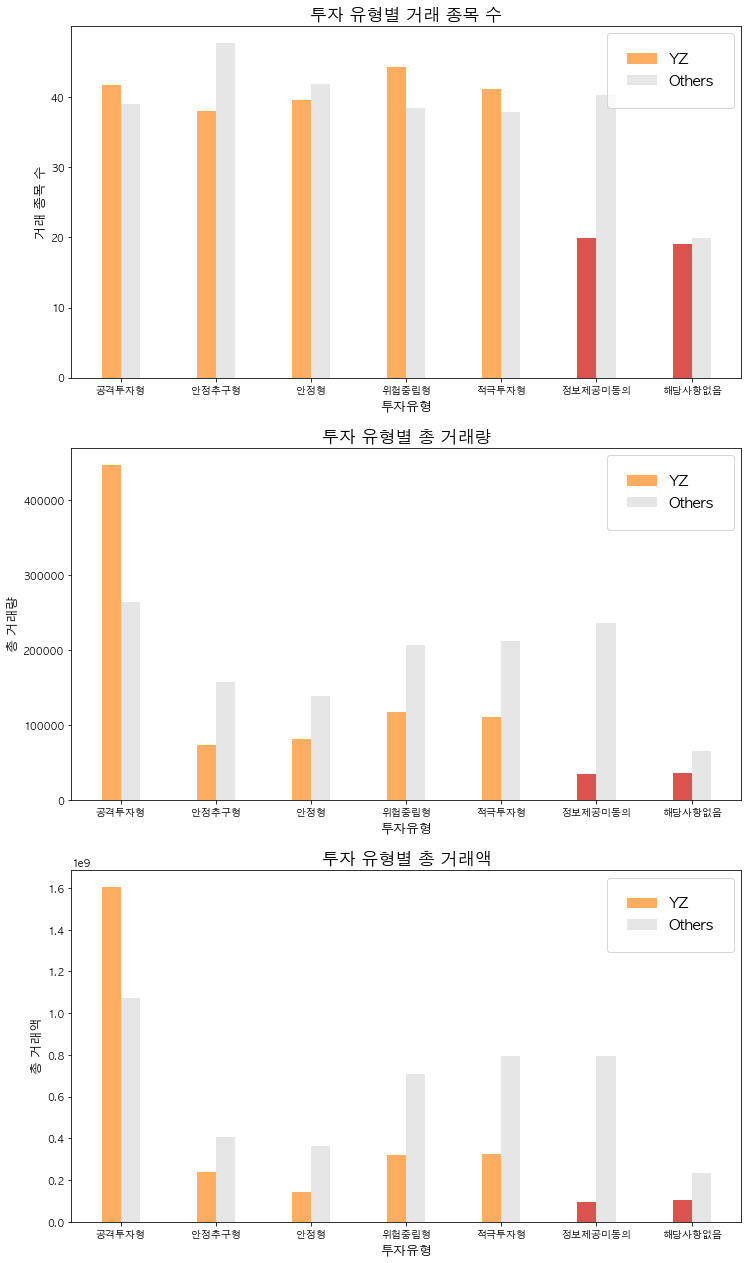

In [104]:
plt.rcParams['figure.figsize'] = [12, 22]

plt.subplot(311)
feature = 'iem_cnt'
text = '거래 종목 수'
bar_plot(generation,feature,text,10)

plt.subplot(312)
feature = 'qty_cns_sum'
text = '총 거래량'
bar_plot(generation,feature,text,100000)

plt.subplot(313)
feature = 'tot_pr_sum'
text = '총 거래액'
bar_plot(generation,feature,text,200000000)

plt.show()

기존 투자성향 분류법은 본인이 스스로에 대한 투자 성향을 응답한 것입니다. 그래프를 보면 해당사항 없음 및 정보제공미동의에 해당하는 고객들은 유형이 분류된 고객보다 거래종목수, 총거래액, 총거래량 모두 현저히 낮은 것을 확인할 수 있습니다. 이는 주식거래를 거의 안하거나 새로 주식 시장에 들어온 사람들로 해석할 수 있습니다. 설문을 통해 투자유형을 분류하는 기존에 방식 특성상 본인이 어떤 투자 성향을 지니고 있는지 모르기 때문에 이에 대해 응답하지 않은 경우에는 <mark>개인화된 서비스나 상품을 제공하는데 어려움</mark>이 있습니다.

### 군집화의 근거

저희는 위의 **1.3. 주식 거래 패턴 비교** 와 **1.4. YZ세대는 하나의 집단으로 정의할 수 없음**를 근거로, <mark>기존 투자성향 분류법을 보완한 군집분석</mark>을 제안합니다. YZ세대는 연관주식을 구매하는 특성이 높고 하나의 집단으로 정의할 수 없다는 로직을 바탕으로, 신규 서비스의 타겟팅을 위해서 새로운 군집분석이 필요하다고 생각하였습니다.

# 2. YZ세대 군집화

## 2.1. Feature 생성

1.4.에서 생성한 [아이디별 거래 종목수,총거래량, 총거래금액]에 거래기간, 평균 거래량, 매수매도수, 거래한종목 유형에 대한 feature를 추가로 생성합니다.

#### 평균 투자 기간
아이디별 계좌별 거래한 종목별 첫 매수부터 마지막 매도까지 평균 기간에 대한 피쳐 생성

In [45]:
cus_act_trd2 = cus_act_trd.sort_values(by = ['cus_id','act_id','iem_cd','orr_dt'])

In [46]:
buying_dt = cus_act_trd2.query('sby_dit_cd == 2').groupby(['cus_id','act_id','iem_cd']).head(1)
buying_dt = buying_dt.rename({'orr_dt': 'buy_dt'},axis = 1)

selling_dt = cus_act_trd2.query('sby_dit_cd == 1').groupby(['cus_id','act_id','iem_cd']).tail(1)
selling_dt = selling_dt.rename({'orr_dt': 'sell_dt'},axis = 1)
selling_dt2 = selling_dt[['cus_id','act_id','iem_cd',"sell_dt"]]

orr_date = buying_dt.merge(selling_dt2,on = ['cus_id','act_id','iem_cd'],how = 'outer')

In [47]:
# 기간내 매수,혹은 매도만 있는 거래나 매도날짜가 더 앞인 거래의 거래기간은 계산하지 않음
orr_date2 = orr_date.query('buy_dt <= sell_dt')
orr_date2['invest_period'] = orr_date2.apply(lambda x: (x['sell_dt']-x['buy_dt']).days
                                           if (x['buy_dt'] <= x['sell_dt']) 
                                           else 9999, axis = 1)
trd_orr = orr_date2.groupby('cus_id')['invest_period']\
    .agg([('mean_invest_period','mean')]).reset_index()

#### 최초 투자 기간; 첫매수이후 첫매도까지의 기간

In [48]:
buying_dt = cus_act_trd2.query('sby_dit_cd == 2').groupby(['cus_id','act_id','iem_cd']).head(1)
buying_dt = buying_dt.rename({'orr_dt': 'buy_dt'},axis = 1)

first_buy_dt = cus_act_trd2.merge(buying_dt[['cus_id','act_id','iem_cd','buy_dt']],on =['cus_id','act_id','iem_cd'] )
selling_dt = first_buy_dt.query('orr_dt >= buy_dt and sby_dit_cd == 1')\
        .groupby(['cus_id','act_id','iem_cd']).head(1)
selling_dt = selling_dt.rename({'orr_dt': 'sell_dt'},axis = 1)

selling_dt2 = selling_dt[['cus_id','act_id','iem_cd',"sell_dt"]]
orr_date = buying_dt.merge(selling_dt2,on = ['cus_id','act_id','iem_cd'],how = 'left')

In [49]:
orr_date2 = orr_date.query('buy_dt <= sell_dt')
orr_date2['invest_period'] = orr_date2.apply(lambda x: (x['sell_dt']-x['buy_dt']).days
                                           if (x['buy_dt'] <= x['sell_dt']) 
                                           else 9999, axis = 1)

first_trd_orr = orr_date2.groupby('cus_id')['invest_period']\
    .agg([('first_invest_period','mean')]).reset_index()

#### 한 종목당 평균 거래량

In [50]:
iem_cns_sum = cus_act_trd.groupby(['cus_id','iem_cd']).cns_qty.agg([('iem_cns_sum','sum')]).reset_index()
cns_mean = iem_cns_sum.groupby('cus_id').iem_cns_sum.agg([('cns_mean', 'mean'),('cns_std', 'std')]).reset_index()

#### 매수매도 빈도수

In [51]:
total_sby = cus_act_trd.groupby(['cus_id']).size().reset_index()
total_sby = total_sby.rename({0 : 'total_sby'},axis = 1) 

In [52]:
sell = cus_act_trd.query('sby_dit_cd == 1').groupby(['cus_id','iem_cd']).size().reset_index()
sell = sell.rename({0:'sell_frequency'},axis = 1)
buy = cus_act_trd.query('sby_dit_cd == 2').groupby(['cus_id','iem_cd']).size().reset_index()
buy = buy.rename({0:'buy_frequency'},axis = 1)
sby = sell.merge(buy,on = ['cus_id','iem_cd'],how = 'outer')
sby_mean = sby.groupby('cus_id')[['sell_frequency','buy_frequency']].mean().reset_index()

#### WICS 종목 개수 열 컬럼 

In [53]:
w = cus_act_trd.groupby(['cus_id','wics_nm1'])['iem_cd'].nunique().reset_index() 
w2 = w.merge(iem_cnt,on = 'cus_id')
w2['wics_ratio'] = w2.iem_cd / w2.iem_cnt

In [54]:
pivot = pd.pivot_table(w2, values = 'wics_ratio', index = 'cus_id',
               columns = 'wics_nm1', fill_value=0)
flattened = pd.DataFrame(pivot.to_records())
flattened.columns = [hdr.replace("('wics_nm1', ", "").replace(")", "") \
                     for hdr in flattened.columns]

#### 데이터 병합

In [55]:
data = data.merge(trd_orr, on = 'cus_id')\
    .merge(first_trd_orr, on = 'cus_id')\
    .merge(cns_mean, on = 'cus_id')\
    .merge(sby_mean, on = 'cus_id')\
    .merge(total_sby, on = 'cus_id')\
    .merge(flattened, on = 'cus_id')
data = data.fillna(0)

## 2.2. 이상치 제거

In [56]:
mz_data = data.query('generation == "MZ"')

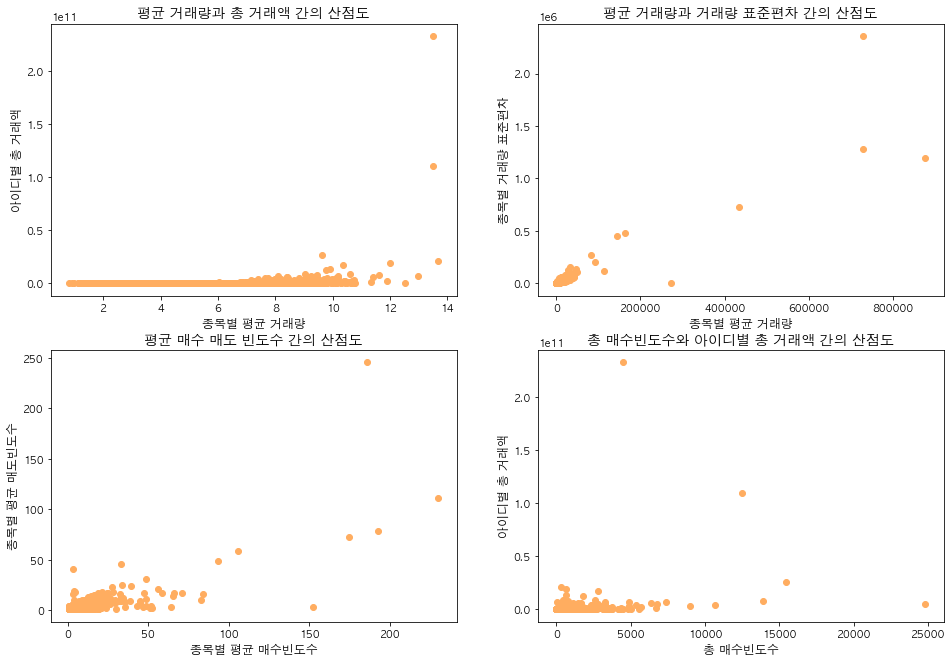

In [105]:
#이상치 제거 전
plt.rcParams['figure.figsize'] = [16, 11]

plt.subplot(221)
plt.scatter(np.log(mz_data['cns_mean']),mz_data['tot_pr_sum'], c = '#ffad60')
plt.xlabel('종목별 평균 거래량', fontsize=12)
plt.ylabel('아이디별 총 거래액', fontsize=12)
plt.title('평균 거래량과 총 거래액 간의 산점도',fontsize=14)

plt.subplot(222)
plt.scatter(mz_data['cns_mean'],mz_data['cns_std'], c = '#ffad60')
plt.xlabel('종목별 평균 거래량', fontsize=12)
plt.ylabel('종목별 거래량 표준편차', fontsize=12)
plt.title('평균 거래량과 거래량 표준편차 간의 산점도',fontsize=14)

plt.subplot(223)
plt.scatter(mz_data['buy_frequency'],mz_data['sell_frequency'], c = '#ffad60')
plt.xlabel('종목별 평균 매수빈도수', fontsize=12)
plt.ylabel('종목별 평균 매도빈도수', fontsize=12)
plt.title('평균 매수 매도 빈도수 간의 산점도',fontsize=14)

plt.subplot(224)
plt.scatter(mz_data['total_sby'],mz_data['tot_pr_sum'], c = '#ffad60')
plt.xlabel('총 매수빈도수', fontsize=12)
plt.ylabel('아이디별 총 거래액', fontsize=12)
plt.title('총 매수빈도수와 아이디별 총 거래액 간의 산점도',fontsize=14)

 
plt.show()

**소수 몇명의 고객이 다른 고객들에 비해 너무 큰 값을 가지고 있습니다. 따라서 보다 나은 특성 파악 및 군집화를 위해 해당 고객을 분석에서 제외합니다.**

In [58]:
mz_data2 = mz_data.query('cns_mean < 80000 and cns_std < 400000 and tot_pr_sum < 10000000000 and buy_frequency < 150 and sell_frequency < 40')

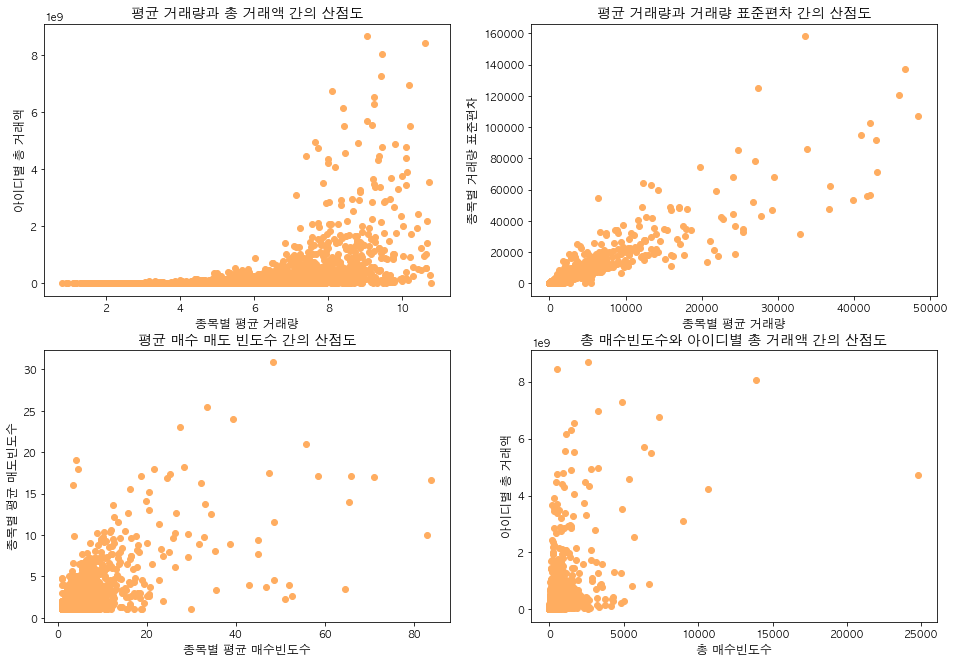

In [106]:
#이상치 제거 후
plt.rcParams['figure.figsize'] = [16, 11]

plt.subplot(221)
plt.scatter(np.log(mz_data2['cns_mean']),mz_data2['tot_pr_sum'], c = '#ffad60')
plt.xlabel('종목별 평균 거래량', fontsize=12)
plt.ylabel('아이디별 총 거래액', fontsize=12)
plt.title('평균 거래량과 총 거래액 간의 산점도',fontsize=14)

plt.subplot(222)
plt.scatter(mz_data2['cns_mean'],mz_data2['cns_std'], c = '#ffad60')
plt.xlabel('종목별 평균 거래량', fontsize=12)
plt.ylabel('종목별 거래량 표준편차', fontsize=12)
plt.title('평균 거래량과 거래량 표준편차 간의 산점도',fontsize=14)

plt.subplot(223)
plt.scatter(mz_data2['buy_frequency'],mz_data2['sell_frequency'], c = '#ffad60')
plt.xlabel('종목별 평균 매수빈도수', fontsize=12)
plt.ylabel('종목별 평균 매도빈도수', fontsize=12)
plt.title('평균 매수 매도 빈도수 간의 산점도',fontsize=14)

plt.subplot(224)
plt.scatter(mz_data2['total_sby'],mz_data2['tot_pr_sum'], c = '#ffad60')
plt.xlabel('총 매수빈도수', fontsize=12)
plt.ylabel('아이디별 총 거래액', fontsize=12)
plt.title('총 매수빈도수와 아이디별 총 거래액 간의 산점도',fontsize=14)

 
plt.show()

## 2.3. 데이터 형태 변환

In [60]:
df = mz_data2

cols = ['iem_cnt','mean_invest_period','first_invest_period','cns_mean','cns_std',
 'sell_frequency','buy_frequency','qty_cns_sum','tot_pr_sum']

cols_nm = ['거래종목수','평균 거래기간','매수매도간 기간',
           '평균 거래량','거래량 표준편차','매도빈도수',
           '총 거래량','총거래빈도','매수 총 거래액']

wics = ['IT', '건강관리', '경기관련소비재',
       '금융', '기타', '산업재', '소재', '에너지', '유틸리티', '커뮤니케이션서비스',
            '필수소비재', '해외주식']

In [61]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[cols])

## 2.4. 군집화[GMM]

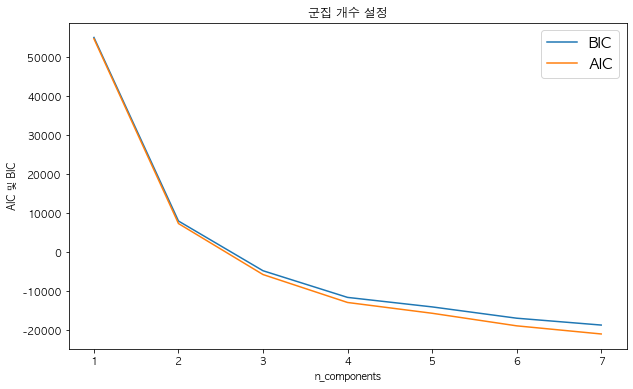

In [107]:
from sklearn import mixture
n_components = np.arange(1, 8)
X = scaled_features
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]
plt.rcParams['figure.figsize'] = [10, 6]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best', prop={'size': 15})
plt.title('군집 개수 설정')
plt.ylabel('AIC 및 BIC')
plt.xlabel('n_components')
plt.show()

AIC, BIC 모두 클러스터 개수가 3개일 때, 엘보우 포인트이므로 클러스터 개수는 3~4개가 적당합니다. 저희는 군집 수를 4개로 설정하고 이후 GMM군집화를 진행했습니다.

In [63]:
X = scaled_features
gmm = mixture.GaussianMixture(n_components=4,random_state = 4).fit(X)
labels = gmm.predict(X)
df['gmm_label'] = labels

In [64]:
gmm = {0: 'Group1',
       1: "Group2",
       2: 'Group3',
       3: 'Group4'}
df['Cluster'] = df['gmm_label'].apply(lambda x : gmm[x])
df = df.sort_values(by = 'gmm_label')

df['dot_size'] = 3
X = df[cols]

fig = px.scatter_3d(
     df, x=np.log(df['iem_cnt']), y=np.log(df['buy_frequency']), z=np.log(df['tot_pr_sum']), 
    color=df['Cluster'],
    title=f'군집화 결과',
    size=df['dot_size'], 
    size_max=10,
    width=600, height=600,
    color_discrete_sequence=['#8DB87C','#fac674','#737495','#68a8ad'],
    labels={'x': '거래 종목 수', 'y': '매도 빈도수', 'z': '총 거래액'}
)
fig.update_layout(margin=dict(l=10, r=10, b=50, t=50))
fig.show()

In [65]:
table = df.groupby(['Cluster']).size().reset_index()
table = table.rename({0:'분포 고객수','Cluster':'군집'},axis = 1)
table

,군집,분포 고객수
0,Group1,810
1,Group2,827
2,Group3,416
3,Group4,800


## 2.5. 군집별 특성파악

### 2.5.1. 군집별 거래 특성 비교

In [66]:
df_cluster = df.groupby('gmm_label').mean().reset_index()
df_cluster = df_cluster.rename({0: "value"},axis = 1)
df_cluster.iloc[:,0:13]

,gmm_label,iem_cnt,qty_cns_sum,tot_pr_sum,cus_age,mean_invest_period,first_invest_period,cns_mean,cns_std,sell_frequency,buy_frequency,total_sby,IT
0,0,14.687654,1206.866667,1.079473e+07,27.913580,26.635780,24.343827,83.055680,108.741497,1.280863,2.157523,49.100000,0.270327
1,1,13.259976,4453.257557,3.610434e+07,29.486094,77.676305,54.995605,380.699950,551.327866,1.938762,3.853441,69.633615,0.241749
2,2,93.028846,415503.055288,1.089412e+09,31.153846,68.927689,25.469945,7339.944188,15672.689562,4.976919,10.633537,1071.122596,0.244347
3,3,58.762500,56352.916250,1.828809e+08,29.806250,27.806149,14.721749,1415.931643,2678.346038,2.011927,3.135499,311.695000,0.237054


In [67]:
colors = ['#8DB87C','#fac674','#737495','#68a8ad']
x_values = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
y_values = df_cluster['iem_cnt']

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=('거래 종목수','평균 투자 기간','최초 투자 기간',
           '매수/매도 빈도수',
           '총 거래량','매수 총 거래액'))

fig.add_trace(go.Bar(
    x= ['Group 1', 'Group 2', 'Group 3', 'Group 4'],
    y=df_cluster['iem_cnt'],
    marker_color=colors,legendgroup='group1',showlegend=False),row=1, col=1)

fig.add_trace(go.Bar(
    x= ['Group 1', 'Group 2', 'Group 3', 'Group 4'],
    y=df_cluster['mean_invest_period'],
    marker_color=colors,legendgroup='group2',showlegend=False),row=1, col=2)

fig.add_trace(go.Bar(
    x= ['Group 1', 'Group 2', 'Group 3', 'Group 4'],
    y=df_cluster['first_invest_period'],
    marker_color=colors,legendgroup='group3'),row=1, col=3)

fig.add_trace(go.Bar(
    x= ['Group 1', 'Group 2', 'Group 3', 'Group 4'],
    y=df_cluster['total_sby'],
    marker_color=colors,legendgroup='group4',showlegend=False),row=2, col=1)

fig.add_trace(go.Bar(
    x= ['Group 1', 'Group 2', 'Group 3', 'Group 4'],
    y=df_cluster['qty_cns_sum'],
    marker_color=colors,legendgroup='group5',showlegend=False),row=2, col=2)

fig.add_trace(go.Bar(
    x= ['Group 1', 'Group 2', 'Group 3', 'Group 4'],
    y=df_cluster['tot_pr_sum'],
    marker_color=colors,legendgroup='group6',showlegend=False),row=2, col=3)

fig.update_layout(height=600, width=900,paper_bgcolor='#ffffff',showlegend=False,
                 plot_bgcolor= '#ffffff', title_text="그룹별 특성비교",
                 legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1
))
fig.update_xaxes(gridcolor = 'rgb(233,233,233)')
fig.update_yaxes(gridcolor = 'rgb(233,233,233)')
fig.show()

+ 첫번째 군집은 거래종목수는 적으나 한종목에 대한 투자기간이 길고 매수와 매도의 간격이 크며 적은자본으로 자주 거래하지않음.
<br>-> <mark>적은 자본, 소수 종목, 장기 투자 </mark><br>

+ 두번째 군집은 거래종목수가 적고 투자기간이 짧으며 거래량 및 거래자본이 작음. <br>-> <mark>매우 적은 자본, 소수 종목, 단기 투자</mark><br>


+ 세번째 군집은 거래 종목수가 많은 편이나 투자기간이 짧고 매수와 매도간의 간격이 좁음. 1,2번 군집보다는 거래량 및 매수매도 빈도수가 잦음. <br>-> <mark>다소 적은 자본, 다수 종목, 단기 투자</mark> <br>


+ 네번째 군집은 큰 자본으로 많는 수의 종목을 거래하며 한 종목에 대한 투자기간이 기나 그 안에서의 매수,매도 등 거래량이 많음. <br>-> <mark>많은 자본, 다수 종목, 장기 투자</mark> <br>


### 2.5.2. YZ세대 군집별 거래 종목 비교 

In [68]:
act_info.drop('act_iem_lst', axis = 1, inplace = True)

In [70]:
cluster_data4 = pd.read_csv('cluster_data4.csv')

In [71]:
# YZ세대 Cluster cus_info와 결합
mz_info = pd.merge(cus_info, cluster_data4, on = 'cus_id')

In [72]:
# 군집 결과에 맞게 cus_id를 나눔
mz_g0 = mz_info.query('gmm_label == 0')
mz_g1 = mz_info.query('gmm_label == 1')
mz_g2 = mz_info.query('gmm_label == 2')
mz_g3 = mz_info.query('gmm_label == 3')

mz_g0_cus = mz_g0['cus_id']
mz_g1_cus = mz_g1['cus_id']
mz_g2_cus = mz_g2['cus_id']
mz_g3_cus = mz_g3['cus_id']

In [73]:
def cluster_item_lst(cus_id_lst, cluster_name):
    print('{}의 YZ고객 비율: {:.4} %'.format(cluster_name, (cus_id_lst.shape[0] / mz_info.shape[0]) * 100))
    
    cus_act_lst = act_info.query('cus_id in @cus_id_lst')['act_id']
    act_trd_lst = trd_kr.query('act_id in @cus_act_lst')

    act_iem_lst = act_trd_lst.groupby('act_id')['iem_cd'].agg([('act_iem_lst',list)]).reset_index()
    cus_act_lst = pd.merge(act_info.query('act_id in @cus_act_lst'), act_iem_lst, on = 'act_id', how = 'left')
    #거래가 없는 계좌 제외
    cus_act_lst.dropna(subset = ['act_iem_lst'], inplace = True)

    cus_id_lst_lst = cus_act_lst.groupby('cus_id')['act_iem_lst'].agg([('cus_iem_lst',list)]) \
    ['cus_iem_lst'].apply(lambda cus_iem_lst : sum(cus_iem_lst, [])).reset_index()

    cus_id_lst = pd.merge(cus_id_lst, cus_id_lst_lst, on = 'cus_id', how = 'left')

    #거래가 없는 고객 제외
    cus_id_lst.dropna(subset = ['cus_iem_lst'], inplace = True)
    
    #iem_cd에 상품 이름과 종목 컬럼 생성
    cus_id_lst['iem_krl_lst'] = cus_id_lst['cus_iem_lst'].apply(lambda iem_lst : list(map(lambda i: iem_name_dict['iem_krl_nm'][i], iem_lst)))
    cus_id_lst['wics_nm3_lst'] = cus_id_lst['cus_iem_lst'].apply(lambda iem_lst : list(map(lambda i: iem_name_dict['wics_nm3'][i], iem_lst)))
    
    return cus_id_lst

In [74]:
mz_g0_iem_lst = cluster_item_lst(mz_g0_cus, 'Group 1')
mz_g1_iem_lst = cluster_item_lst(mz_g1_cus, 'Group 2')
mz_g2_iem_lst = cluster_item_lst(mz_g2_cus, 'Group 3')
mz_g3_iem_lst = cluster_item_lst(mz_g3_cus, 'Group 4')

Group 1의 YZ고객 비율: 28.83 %
Group 2의 YZ고객 비율: 28.33 %
Group 3의 YZ고객 비율: 28.3 %
Group 4의 YZ고객 비율: 14.54 %


In [75]:
def cluster_iem_rules(cus_iem_lst, as_rules, min_support = 0.2, min_confidence = 0.5):
    encoder = TransactionEncoder()
    encoder_array = encoder.fit_transform(cus_iem_lst)
    
    df = pd.DataFrame(
    encoder_array, 
    columns=encoder.columns_
    )
      
    apriori_df = apriori(df, 
        min_support=min_support,
        use_colnames=True)
    
    apriori_df['length'] = apriori_df['itemsets'].apply(lambda x: len(x))
    
    if as_rules :
        
        iem_rules = association_rules(
        apriori_df, 
        metric="confidence",
        min_threshold=min_confidence, 
        support_only=False
        )
    
        return iem_rules
    
    else : return apriori_df

### 군집 별 거래 업종(WICS) 비율 비교

In [76]:
mz_g0_wics = cluster_iem_rules(mz_g0_iem_lst['wics_nm3_lst'], as_rules = False)
mz_g0_wics['cluster'] = 'Group 1'

mz_g1_wics = cluster_iem_rules(mz_g1_iem_lst['wics_nm3_lst'], as_rules = False)
mz_g1_wics['cluster'] = 'Group 2'

mz_g2_wics = cluster_iem_rules(mz_g2_iem_lst['wics_nm3_lst'], min_support = 0.4, as_rules = False)
mz_g2_wics['cluster'] = 'Group 3'

mz_g3_wics = cluster_iem_rules(mz_g3_iem_lst['wics_nm3_lst'], min_support = 0.4, as_rules = False)
mz_g3_wics['cluster'] = 'Group 4'

In [77]:
# 각 군집 별 거래량 top 5개 업종 추출
each_cluster_top5_wics = pd.concat([mz_g0_wics.query('length == 1').sort_values(by = 'support', ascending = False).head(5),
          mz_g1_wics.query('length == 1').sort_values(by = 'support', ascending = False).head(5),
          mz_g2_wics.query('length == 1').sort_values(by = 'support', ascending = False).head(5),
          mz_g3_wics.query('length == 1').sort_values(by = 'support', ascending = False).head(5)], axis = 0)
1
target_wics = list(set(each_cluster_top5_wics['itemsets'].apply(lambda x : list(x)[0].strip())))
print('4개의 군집에서 추출된 업종의 개수 : {} 개'.format(len(target_wics)))

4개의 군집에서 추출된 업종의 개수 : 8 개


In [78]:
colors = ['#8DB87C','#fac674','#737495','#68a8ad']
names = ['Group 1','Group 2','Group 3','Group 4']
plot_data = []
for color,name, df in zip(colors,names, [mz_g0_wics,mz_g1_wics,mz_g2_wics,mz_g3_wics]):
    df['itemsets'] = df['itemsets'].apply(lambda x : list(x)[0].strip()).to_list()
    plot_data.append(go.Bar(name= name, x=df.query('length == 1 and itemsets in @target_wics')['itemsets'].to_list(), 
                            y=df.query('length == 1 and itemsets in @target_wics')['support'].to_list(),marker_color=color))

fig = go.Figure(data=plot_data)
# Change the bar mode
fig.update_layout(barmode='group', paper_bgcolor='#ffffff',bargap=0.4, xaxis_tickfont_size= 10,
                 plot_bgcolor= '#ffffff',title_text='군집 별 거래 비율 상위 5개 업종 비교')
fig.update_xaxes(gridcolor = 'rgb(233,233,233)',title_text="업종")
fig.update_yaxes(gridcolor = 'rgb(233,233,233)',title_text="군집 내 고객들의 거래 비율")

fig.show()
# 각 군집 안에서 20% 미만이 구매한 항목은 표시되지 않음.

- Group 1과 Group 2의 경우 `반도체와반도체장비`를 제외하면 50%가 넘는 비율이 가지고 있는 특정 업종이 없습니다.
- `자동차`의 경우에는 Group 1과 Group 2만이 해당 업종을 20% 이상 구매하였습니다.

### 군집 별 종목 구매비율 비교

In [79]:
mz_g0_iem = cluster_iem_rules(mz_g0_iem_lst['iem_krl_lst'], as_rules = False, min_support = 0.1)
mz_g0_iem['cluster'] = 'Group 1'

mz_g1_iem = cluster_iem_rules(mz_g1_iem_lst['iem_krl_lst'], as_rules = False, min_support = 0.1)
mz_g1_iem['cluster'] = 'Group 2'

mz_g2_iem = cluster_iem_rules(mz_g2_iem_lst['iem_krl_lst'], as_rules = False, min_support = 0.1)
mz_g2_iem['cluster'] = 'Group 3'

mz_g3_iem = cluster_iem_rules(mz_g3_iem_lst['iem_krl_lst'], as_rules = False, min_support = 0.1)
mz_g3_iem['cluster'] = 'Group 4'

In [80]:
each_cluster_top5_iem = pd.concat([mz_g0_iem.query('length == 1').sort_values(by = 'support', ascending = False).head(5),
          mz_g1_iem.query('length == 1').sort_values(by = 'support', ascending = False).head(5),
          mz_g2_iem.query('length == 1').sort_values(by = 'support', ascending = False).head(5),
          mz_g3_iem.query('length == 1').sort_values(by = 'support', ascending = False).head(5)], axis = 0)

target_iem = list(set(each_cluster_top5_iem['itemsets'].apply(lambda x : list(x)[0].strip())))
print('4개의 군집에서 추출된 종목의 개수 : {} 개'.format(len(target_iem)))

4개의 군집에서 추출된 종목의 개수 : 11 개


In [81]:
colors = ['#8DB87C','#fac674','#737495','#68a8ad']
names = ['Group 1','Group 2','Group 3','Group 4']
plot_data = []
for color,name, df in zip(colors,names,[mz_g0_iem,mz_g1_iem,mz_g2_iem,mz_g3_iem]):
    df['itemsets'] = df['itemsets'].apply(lambda x : list(x)[0].strip()).to_list()
    plot_data.append(go.Bar(name= name, x=df.query('length == 1 and itemsets in @target_iem')['itemsets'].to_list(), 
                            y=df.query('length == 1 and itemsets in @target_iem')['support'].to_list(),marker_color=color))

fig = go.Figure(data=plot_data)
# Change the bar mode
fig.update_layout(barmode='group',paper_bgcolor='#ffffff',bargap=0.4, xaxis_tickfont_size= 10,
                 plot_bgcolor= '#ffffff' ,title_text='군집 별 거래 비율 상위 5개 종목 비교')
fig.update_xaxes(gridcolor = 'rgb(233,233,233)',title_text="종목")
fig.update_yaxes(gridcolor = 'rgb(233,233,233)',title_text="군집 내 고객들의 거래 비율")

fig.show()

# 각 군집 안에서 10% 미만이 거래한 항목은 표시되지 않음.

- Group 1과 Group 2의 경우 `삼성전자보통주`를 제외하면 50%가 넘는 비율이 가지고 있는 특정 종목이 없습니다.
- Group 1이나 Group 2에서 특히 많이 사는 종목은 없는 반면에 Group 3과 Group 4는 `남선알미늄보통주`,`씨젠`,`빅텍`,`파미셀보통주`,`국일제지`,`신풍제약보통주` 등 해당 군집에서 많이 사는 종목이 있는 것을 확인하였습니다.

### 군집 별 특성 파악의 결과


Group 1과 Group 2은 **뚜렷한 방향성**을 설정하지 않고, 주식시장에서 활동하고 있습니다.

### 군집 별 거래 종목 조합 비교

In [82]:
mz_g0_iem_rules = cluster_iem_rules(mz_g0_iem_lst['iem_krl_lst'], as_rules = True, min_support = 0.1)
mz_g1_iem_rules = cluster_iem_rules(mz_g1_iem_lst['iem_krl_lst'], as_rules = True, min_support = 0.1)
mz_g2_iem_rules = cluster_iem_rules(mz_g2_iem_lst['iem_krl_lst'], as_rules = True, min_support = 0.1)
mz_g3_iem_rules = cluster_iem_rules(mz_g3_iem_lst['iem_krl_lst'], as_rules = True, min_support = 0.1, min_confidence = 0.6)

In [83]:
print('Group 1의 종목 조합 개수 : ', mz_g0_iem_rules.shape[0])
print('Group 2의 종목 조합 개수 : ', mz_g1_iem_rules.shape[0])
print('Group 3의 종목 조합 개수 : ', mz_g2_iem_rules.shape[0])
print('Group 4의 종목 조합 개수 : ', mz_g3_iem_rules.shape[0])

Group 1의 종목 조합 개수 :  3
Group 2의 종목 조합 개수 :  6
Group 3의 종목 조합 개수 :  82
Group 4의 종목 조합 개수 :  3739


# 3. 유형(군집)별 서비스의 필요성 & 기대효과


## 3.1.유형별 서비스의 필요성

#### 1. YZ 세대를 위한 별도의 서비스가 필요  
&emsp;- 2020년부터 YZ 세대의 투자금액의 성장률이 다른 세대의 **투자금액의 성장률**보다 확연히 큰 모습을 보입니다.  
&emsp;- YZ 세대의 투자자는 다른 세대의 투자자에 비해 **인지도가 높은 종목**에 투자하는 성향을 보입니다.  
&emsp;- YZ 세대의 투자자 중 **거래 종목 패턴**이 발견되는 경우가 다른 세대의 투자자들 보다 많습니다.  
&emsp;- <mark>적은 종목에 대해 많은 거래가 패턴을 가지고 이루어지는 YZ세대만의 특성을 바탕으로 연관분석을 활용한 서비스</mark>가 적합하다고 판단하였습니다.  


#### 2. YZ 세대는 여러가지의 투자특성을 가진 Group에 고르게 분포  
&emsp;- `투자성향 설문 컬럼(ivs_icn_cd)`과  리서치 자료를 통해, YZ세대 투자자 모두를 하나의 Group으로 정의하기 어렵다고 판단하였습니다.  
&emsp;- 또한 기존의 `투자성향 설문 컬럼(ivs_icn_cd)`에 '해당사항없음'또는 '정보제공미동의'의 비율이 30%가 넘는다는 점을 고려하여, <mark>투자기간과 투자금액, 투자종목의 다양성 등을 바탕으로 YZ 세대 투자자들의 투자특성을 새롭게 정의</mark>하였습니다.  
&emsp;- 위의 분석을 통해 아래와 같은 결과를 얻을 수 있었습니다.  
&emsp;&emsp;Group 1 (YZ 세대의 28.8 %) : <mark>적은 자본, 소수 종목, 장기 투자 </mark><br>
&emsp;&emsp;Group 2 (YZ 세대의 28.3 %) : <mark>매우 적은 자본, 소수 종목, 단기 투자</mark><br>
&emsp;&emsp;Group 3 (YZ 세대의 28.3 %): <mark>다소 적은 자본, 다수 종목, 단기 투자</mark> <br>
&emsp;&emsp;Group 4 (YZ 세대의 14.5 %): <mark>많은 자본, 다수 종목, 장기 투자</mark> <br>

**YZ세대 내에서도 다양한 투자특성을 가지기 때문에, 이러한 특성을 고려한 유형별 서비스를 제공하는 것이 필요합니다.**

## 3.2.유형별 서비스 예시 제공

#### Group 1 과 Group 2에 속하는 고객을 위한 서비스
&emsp;- Group 1과 Group 2에 속하는 경우 <mark>투자하는 종목이 다른 Group에 비해 확연히 적다는 것과 거래 구매의 패턴이 정해져있지 않다는 것</mark>을 확인하였습니다.  
&emsp;- 해당 그룹에 '해당사항없음'에 포함된 고객이 많다는 점, 투자 종목뿐 아니라 매수/매도 빈도 수와 총 거래량 또한 적다는 점 때문에, <mark>아직 뚜렷한 투자성향을 설정하지 못 한채로 주식시장에 진입한 고객</mark>이라고 판단하였습니다.  
&emsp;- 해당 그룹에 속하는 고객들이 아직 투자하지 않은 친숙하고 투자할만하다고 주식을 추천해주는 방식으로 좀 더 편하게 주식시장에서 활동하도록 하기 위한 서비스가 필요하다고 판단하였습니다.  
<br>
&emsp;- 서비스 제공 타겟으로 설정한 Group 1과 Group 2는 **투자 기간과 종목 선택**에 있어서 차이가 나는 모습을 보여주었습니다.  
&emsp;- 그렇기 때문에, <mark>그룹의 특성과 고객들이 거래한 주식을 토대로 적절한 종목을 추천해주는 서비스</mark>를 만들어보았습니다.

#### 서비스 제공 기준 설정
상품을 구매하는데 있어서 Group 4의 경우 Group 1과 2과 다르게 다양한 **패턴**이 존재한다는 것을 확인했습니다.  
-> <mark>Group 4의 패턴을 통해, Group 1과 2에 해당되는 고객들에게 상품을 추천</mark>

Group 4의 조합을 Group 1과 2에 추천해주기 위해서는 우선 순위가 필요합니다.  
-> <mark>어떤 조합을 우선 추천해주어야할까? (기준 설정)</mark>

1. Group 3의 연관 상품 간 신뢰도 : Group 4에서 연관성이 높은 주식 -> Group 3의 연관 상품 간 신뢰도 0.6 이상
2. MZ세대에서 가지고 있는 비율이 높은 주식 : MZ세대에 친숙한 주식 -> 모든 MZ세대 고객의 종목 Support를 통한 우선순위 설정

In [84]:
mz_iem_lst = cluster_item_lst(mz_info['cus_id'],'전체')
mz_iem = cluster_iem_rules(mz_iem_lst['iem_krl_lst'], as_rules = False, min_support = 0.05)

mz_iem_support = mz_iem.query('length == 1').drop('length', axis = 1).rename(columns = {'support': 'mz_support'})

전체의 YZ고객 비율: 100.0 %


In [85]:
mz_g3_iem_rules_ = pd.merge(mz_g3_iem_rules, mz_iem_support, left_on = 'consequents', right_on = 'itemsets') \
                    .drop('itemsets', axis = 1)

In [86]:
mz_g3_iem_rules_['antecedents_length'] = mz_g3_iem_rules_['antecedents'].apply(lambda x : len(x))
mz_g3_iem_rules_['consequents_length'] = mz_g3_iem_rules_['consequents'].apply(lambda x : len(x))

In [87]:
mz_g3_iem_rules_['antecedents'] = mz_g3_iem_rules_['antecedents'] \
                                 .apply(lambda x : list(map(lambda j : j.strip(), list(x)))).to_list()
mz_g3_iem_rules_['consequents'] = mz_g3_iem_rules_['consequents'] \
                                 .apply(lambda x : list(map(lambda j : j.strip(), list(x)))).to_list()

In [88]:
mz_g0_target = mz_g0_iem.query('length == 1')
mz_g1_target = mz_g1_iem.query('length == 1')

In [89]:
mz_g0_target_iem = mz_g0_target["itemsets"].to_list()
mz_g0_rec_lst = mz_g3_iem_rules_[mz_g3_iem_rules_['antecedents'] \
                 .apply(lambda iem_lst : sum(list(map(lambda x : 1 if x in mz_g0_target_iem else 0, iem_lst)))) != 0]
mz_g0_rec_lst = mz_g0_rec_lst[['antecedents','consequents','confidence','mz_support']] \
                .sort_values(by = ['confidence','mz_support'],ascending = False)
mz_g0_rec_lst.head(15)

,antecedents,consequents,confidence,mz_support
1585,"[카카오보통주, 현대자동차보통주]",[삼성전자보통주],0.891304,0.547755
1584,"[카카오보통주, 에스케이하이닉스보통주]",[삼성전자보통주],0.872340,0.547755
1507,[NAVER보통주],[삼성전자보통주],0.813333,0.547755
1541,[현대자동차보통주],[삼성전자보통주],0.804598,0.547755
463,"[현대바이오랜드, 삼성전자보통주]",[남선알미늄보통주],0.800000,0.172131
1527,[에스케이하이닉스보통주],[삼성전자보통주],0.797753,0.547755
376,"[삼성전자보통주, 메가엠디]",[남선알미늄보통주],0.796610,0.172131
1542,"[NAVER보통주, 카카오보통주]",[삼성전자보통주],0.796296,0.547755
1506,[LG화학보통주],[삼성전자보통주],0.788462,0.547755
2911,"[삼성전자보통주, 랩지노믹스]",[씨젠],0.788462,0.174982


In [90]:
mz_g1_target_iem = mz_g1_target["itemsets"].to_list()
mz_g1_rec_lst = mz_g3_iem_rules_[mz_g3_iem_rules_['antecedents'] \
                 .apply(lambda iem_lst : sum(list(map(lambda x : 1 if x in mz_g1_target_iem else 0, iem_lst)))) != 0]
mz_g1_rec_lst = mz_g1_rec_lst[['antecedents','consequents','confidence','mz_support']] \
                .sort_values(by = ['confidence','mz_support'],ascending = False)
mz_g1_rec_lst.head(15)

,antecedents,consequents,confidence,mz_support
615,"[현대바이오랜드, 디피씨보통주, 씨젠]",[남선알미늄보통주],0.976190,0.172131
659,"[신풍제약보통주, 현대바이오랜드, 씨젠]",[남선알미늄보통주],0.957447,0.172131
628,"[신풍제약보통주, 메가엠디, 씨젠]",[남선알미늄보통주],0.931818,0.172131
648,"[씨젠, 부광약품보통주, 이원다이애그노믹스]",[남선알미늄보통주],0.931818,0.172131
670,"[현대바이오랜드, 웰크론, 씨젠]",[남선알미늄보통주],0.931818,0.172131
1860,"[현대바이오랜드, 남선알미늄보통주, 씨젠]",[신풍제약보통주],0.918367,0.159658
607,"[신풍제약보통주, 디피씨보통주, 씨젠]",[남선알미늄보통주],0.914894,0.172131
652,"[신풍제약보통주, 수젠텍, 씨젠]",[남선알미늄보통주],0.914894,0.172131
653,"[신풍제약보통주, 아난티, 씨젠]",[남선알미늄보통주],0.913043,0.172131
671,"[현대바이오랜드, 이원다이애그노믹스, 씨젠]",[남선알미늄보통주],0.913043,0.172131


In [91]:
print('Group 1에서 10% 이상 거래한 종목 개수 : {} 개'.format(len(mz_g0_target_iem)))
print('Group 1에서 10% 이상 거래한 종목을 바탕으로 한 추천 리스트 : {} 개 \n'.format(mz_g0_rec_lst.shape[0]))

print('Group 2에서 10% 이상 거래한 종목 개수 : {} 개'.format(len(mz_g1_target_iem)))
print('Group 2에서 10% 이상 거래한 종목을 바탕으로 한 추천 리스트 : {} 개'.format(mz_g1_rec_lst.shape[0]))

Group 1에서 10% 이상 거래한 종목 개수 : 9 개
Group 1에서 10% 이상 거래한 종목을 바탕으로 한 추천 리스트 : 79 개 

Group 2에서 10% 이상 거래한 종목 개수 : 9 개
Group 2에서 10% 이상 거래한 종목을 바탕으로 한 추천 리스트 : 299 개


### Group 2에 대한 추천 리스트 예시

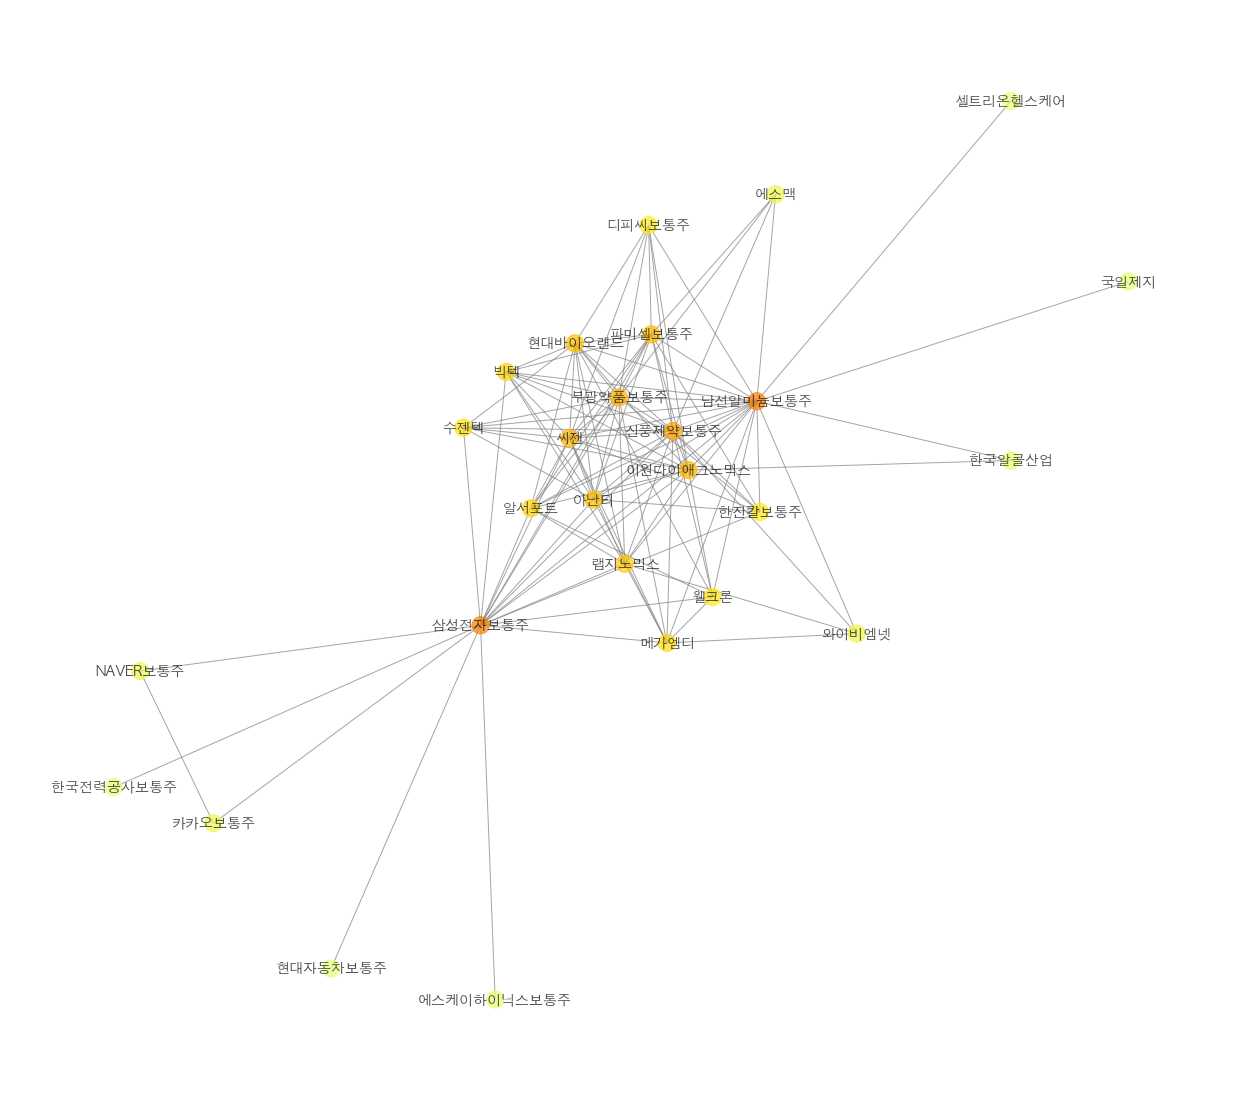

In [109]:
G = nx.Graph()
ar = mz_g1_rec_lst \
.apply(lambda x : (x['antecedents'][0], x['consequents'][0]), axis = 1)
G.add_edges_from(ar)

pr = nx.pagerank(G)

plt.figure(figsize = (22,20)); plt.axis('off')
#pos = nx.planar_layout(G)
nx.draw_networkx(G, font_family ='AppleGothic', font_size = 14,
                 node_color = list(pr.values()), 
                alpha = 0.7, edge_color = '.5', cmap = plt.cm.Wistia)

## 3.3. 서비스 고도화시 기대효과

### YZ세대 유입을 통한 마켓쉐어 & 리텐션율 확보

**"올해 새로 유입된 개인투자자들은 상대적으로 젊은 층이 증가했다...
주식 투자자들의 인구 구조가 본격적으로 달라진 셈이다.
젊은 세대의 주식 투자 관심이 증가하고, 실제 투자하는 규모도 늘면서 
증권사들의 고객 성격도 조금씩 변화했다."** 연합뉴스

비대면 계좌개설이 허용된 이후, 언택트 투자 열기와 맞물려 증권사들이 고객 유치 경쟁을 치열하게 펼치고 있습니다. 낮은 고정비용(수수료 등)을 무기 삼아 마케팅을 하는 것이 가장 대표적인 케이스입니다. 이러한 마케팅을 펼치는 이유는 전통적 수익원인 수탁수수료와 더불어 신규고객 유입을 통해 예치금을 확보하여 신용대출 등으로 수익을 창출하고자 하기 때문입니다. 

다음은 2020년 6월 증권사 위탁매매 점유율 수익 및 약정기준 현황입니다.

<img src="https://drive.google.com/uc?id=13y_NwVXWKvgkkWeCX8eOOmP0AkXh0Jc6" width = 600>

NH투자증권은 수익기준 점유율 2위이며, 약정기준 점유율 4위입니다. 약정기준 점유율 1위인 K사는 지점없이 온라인으로만 사업하는 증권사 입니다. 언택트 투자 열기와 맞물려 역량을 발휘해 전분야 비대면 서비스를 제공하여 호실적을 내고 있습니다. NH 투자증권이 1위로 도약하기 위해서는 이러한 흐름 속에서 비대면 전략과 더불어 차별성 있는 서비스를 제공해야 합니다. 따라서 향상된 구매력을 가진 YZ세대를 타겟으로 맞춤형 신규 서비스를 제공을 통해 마켓쉐어와 리텐션을 확보하는 전략을 구사해야 합니다.

### 신규 서비스 제안

<개인화 추천서비스 mock up>

<img src="https://drive.google.com/uc?id=1SU-bkCq9rvhdzssbM2NZtXTN2C1i_Y0a" width = 800>

<img src="https://drive.google.com/uc?id=1QZr38JTDxOO7GoNgSgqTLPlx9pjg1fJG" width = 800>

저희는 위와같은 분석을 바탕으로 투자성향 MBTI 서비스를 제안 드립니다.

YZ세대는 개인화와 재미를 추구하는 세대입니다.
이러한 그들의 특성을 타겟팅하여, YZ세대의 흥미를 끌 수 있는 투자성향 MBTI 서비스를 제안합니다. 우선 이를 바탕으로 신규 유저 유입을 유도합니다.
이후, 개인화 추천서비스를 제공하여 NH투자증권에 Lock In 하는 전략 입니다.
구매한 종목과 연관 구매한 상품을 추천하는 알고리즘을 사용하기 때문에,
서비스가 무겁고 복잡하지 않아 MZ세대가 선호하는 MTS에서도 원활하게 서비스가 가능하다는 장점 또한 가지고 있습니다.
상기 서비스를 통해 YZ세대 신규 유입 및 Lock in을 야기하여 NH투자증권의 시장점유율 확보의 효과를 기대합니다.